# Self-RAG (Self-Reflective Retrieval-Augmented Generation)

Self-RAG는 2023년에 제안된 검색 증강 생성(RAG)의 발전된 형태로, 언어 모델이 **스스로 검색의 필요성을 판단**하고 **생성된 답변의 품질을 평가**하는 프레임워크입니다.

### 핵심 개념

기존 RAG는 항상 외부 문서를 검색하여 답변을 생성하지만, Self-RAG는 언어 모델이 다음을 스스로 결정합니다:

1. **검색이 필요한지 여부**
2. **검색된 문서가 관련성이 있는지**
3. **생성된 답변이 문서에 근거하는지**
4. **최종 답변이 유용한지**

### 주요 구성 요소

#### 1. Reflection Tokens (반성 토큰)
Self-RAG는 특수한 토큰들을 사용하여 자기 평가를 수행합니다:

- **Retrieve**: 검색이 필요한지 판단
- **ISREL** (Is Relevant): 검색된 문서의 관련성 평가
- **ISSUP** (Is Supported): 답변이 문서에 근거하는지 평가
- **ISUSE** (Is Useful): 최종 답변의 유용성 평가

```
질문 입력
    ↓
[Retrieve 판단] 
    ↓
필요시 문서 검색
    ↓
[ISREL로 문서 평가]
    ↓
답변 생성
    ↓
[ISSUP로 근거 확인]
    ↓
[ISUSE로 품질 평가]
    ↓
최종 답변 출력
```

### 장점

1. **적응적 검색**: 모든 질문에 검색하지 않고 필요할 때만 검색
2. **품질 보장**: 생성된 답변의 신뢰성과 근거를 자체 검증
3. **효율성**: 불필요한 검색을 줄여 비용과 지연시간 감소
4. **환각 감소**: 문서 근거 여부를 확인하여 잘못된 정보 생성 방지

### 기존 RAG와의 차이

| 구분 | 기존 RAG | Self-RAG |
|------|---------|----------|
| 검색 시점 | 항상 검색 | 필요시에만 검색 |
| 품질 검증 | 없음 | 자체 평가 메커니즘 |
| 유연성 | 고정된 파이프라인 | 동적으로 적응 |

### 실제 응용

Self-RAG는 다음과 같은 상황에서 특히 유용합니다:

- **사실 기반 질문**: "2024년 올림픽은 어디서 개최되었나요?" → 검색 필요
- **일반 지식**: "하늘은 왜 파란가요?" → 검색 불필요
- **복잡한 추론**: 여러 문서를 비교하고 평가해야 하는 경우

Self-RAG는 언어 모델에 **메타인지(metacognition)** 능력을 부여하여, 더 신뢰할 수 있고 효율적인 RAG 시스템을 구현하는 혁신적인 접근법입니다.

Self-RAG는 검색된 문서와 생성 결과에 대한 자기-반성 / 자기-평가를 통합한 RAG 전략입니다.

[논문](https://arxiv.org/abs/2310.11511)에서는 몇 가지 의사결정이 이루어집니다:

1. 검색기 `R`로부터 검색을 수행해야 하는가?
- 입력: `x (질문)` 또는 `x (질문)`, `y (생성 결과)`
- `R`로 `D` 청크들을 검색할 시점을 결정
- 출력: `yes, no, continue`

2. 검색된 문단들 `D`가 질문 `x`와 관련이 있는가?
- 입력: `D` 내의 각 `d`에 대해 (`x (질문)`, `d (청크)`)
- `d`가 `x`를 해결하는 데 유용한 정보를 제공하는가?
- 출력: `relevant, irrelevant`

3. `D` 내의 각 청크로부터 생성된 LLM 결과가 해당 청크와 관련이 있는가 (환각 등)?
- 입력: `D` 내의 각 `d`에 대해 `x (질문)`, `d (청크)`, `y (생성 결과)`
- `y (생성 결과)` 내의 검증 가능한 모든 진술이 `d`에 의해 뒷받침되는가?
- 출력: `{fully supported, partially supported, no support}`

4. `D` 내의 각 청크로부터 생성된 LLM 결과가 `x (질문)`에 대한 유용한 응답인가?
- 입력: `D` 내의 각 `d`에 대해 `x (질문)`, `y (생성 결과)`
- `y (생성 결과)`가 `x (질문)`에 대한 유용한 응답인가?
- 출력: `{5, 4, 3, 2, 1}`

우리는 [LangGraph](https://langchain-ai.github.io/langgraph/)를 사용하여 이러한 아이디어들 중 일부를 처음부터 구현할 것입니다.


![](https://i.imgur.com/AWsYXVL.png)



- 참고 자료: https://wikidocs.net/270687
- 관련 논문: https://arxiv.org/abs/2310.11511
- 랭그래프 튜토리얼: https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_self_rag/

## 환경 설정

In [ ]:
%%capture --no-stderr
%pip install -Uq langchain_community tiktoken langchain-openai langchainhub faiss-cpu langchain langgraph

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## Retriever
블로그 게시물 3개를 임베딩합니다.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

# ===== 1. 데이터 수집 =====
# 분석할 웹페이지 URL 목록 정의
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",  # AI 에이전트 관련 포스트
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",  # 프롬프트 엔지니어링 관련 포스트
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",  # LLM 공격 기법 관련 포스트
]

# 각 URL에서 웹 페이지 내용을 로드
# WebBaseLoader를 사용하여 HTML 콘텐츠를 다운로드하고 파싱
docs = [WebBaseLoader(url).load() for url in urls]

# 중첩된 리스트를 평탄화(flatten)하여 단일 리스트로 변환
# docs는 [[doc1], [doc2], [doc3]] 형태이므로 [doc1, doc2, doc3]로 변환
docs_list = [item for sublist in docs for item in sublist]


# ===== 2. 문서 분할 =====
# RecursiveCharacterTextSplitter 생성
# tiktoken 인코더를 사용하여 토큰 기반으로 문서를 분할
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,  # 각 청크의 최대 토큰 수 (약 250 토큰)
    chunk_overlap=0,  # 청크 간 겹치는 토큰 수 (0이면 겹침 없음)
)

# 로드된 문서들을 작은 청크로 분할
# 큰 문서를 작은 단위로 나누어 임베딩 및 검색 성능 향상
doc_splits = text_splitter.split_documents(docs_list)


# ===== 3. 벡터 DB 생성 및 검색기 설정 =====
# FAISS 벡터 데이터베이스 생성
# 분할된 문서들을 임베딩하여 벡터 형태로 저장
vectorstore = FAISS.from_documents(
    documents=doc_splits,  # 분할된 문서 청크들
    embedding=OpenAIEmbeddings(
        model="text-embedding-3-small"  # OpenAI의 임베딩 모델 사용
    ),
)

# 벡터스토어를 검색기(retriever)로 변환
retriever = vectorstore.as_retriever()

In [ ]:
retriever.invoke("AI 에이전트란 무엇인가요?")

[Document(id='4d8fcb86-4690-4193-aa0f-e83c87106969', metadata={'source': 'https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/', 'title': "Adversarial Attacks on LLMs | Lil'Log", 'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to outpu

## 검색 평가자(Retrieval Grader)

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing import Annotated


# ===== 1. 출력 스키마 정의 =====
class GradeDocuments(BaseModel):
    """검색된 문서가 질문과 관련이 있는지 검증"""

    binary_score: Annotated[str, Field(..., description="yes 또는 no")]


# ===== 2. LLM 모델 설정 =====
# ChatOpenAI 인스턴스 생성
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# LLM에 구조화된 출력 형식 적용
# GradeDocuments 스키마에 맞춰 응답을 자동으로 파싱
structured_llm_grader = llm.with_structured_output(GradeDocuments)


# ===== 3. 프롬프트 템플릿 구성 =====
# 시스템 메시지: LLM의 역할과 작업 방식을 정의
system = """당신은 검색된 문서가 사용자 질문과 얼마나 관련성이 있는지 평가하는 채점자입니다. \n
    엄격한 테스트일 필요는 없습니다. 목표는 오류 검색 결과를 걸러내는 것입니다. \n
    문서에 사용자 질문과 관련된 키워드나 의미론적 내용이 포함되어 있다면 관련성이 있다고 평가하십시오. \n
    문서가 질문과 관련이 있는지 여부를 나타내기 위해 'yes' 또는 'no'로 응답하세요."""

# ChatPromptTemplate 생성
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 문서: \n\n {document} \n\n 사용자 질문: {question}"),
    ]
)


# ===== 4. 체인 구성 =====
retrieval_grader = grade_prompt | structured_llm_grader


# ===== 5. 실행 및 테스트 =====
question = "에이전트 메모리"

# retriever를 사용하여 질문과 관련된 문서들을 검색
docs = retriever.invoke(question)
doc_txt = docs[1].page_content  # 첫번째 문서 선택

# retrieval_grader 체인 실행
result = retrieval_grader.invoke({"question": question, "document": doc_txt})
print(result)  # 예상 출력 형태: binary_score='yes' 또는 binary_score='no'

binary_score='yes'


## 답변 생성(Generate)

In [ ]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

에이전트 메모리는 크게 단기 메모리와 장기 메모리로 나뉩니다. 단기 메모리는 모델의 인-컨텍스트 학습을 통해 제한된 범위 내에서 정보를 처리하며, 장기 메모리는 외부 벡터 저장소를 활용해 무한에 가까운 정보를 장기간 저장하고 빠르게 검색할 수 있게 합니다. 이를 통해 에이전트는 과거 정보를 기억하고 활용하여 문제 해결 능력을 향상시킵니다.


## 환각 평가(Hallucination Grader)

In [34]:
class GradeHallucinations(BaseModel):
    """LLM 답변이 환각이 없는지 여부"""

    binary_score: Annotated[str, Field(..., description="yes 또는 no")]


llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

system = """당신은 LLM 답변이 검색된 사실 자료에 근거하거나 이를 뒷받침하는지 평가하는 채점자입니다. \n
'yes' 또는 'no'로 응답하십시오. 'yes'는 답변이 사실 집합에 근거하거나 이를 뒷받침함을 의미합니다."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "검색된 사실 자료: \n\n {documents} \n\n LLM 답변: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

## 답안 평가(Answer Grader)

In [35]:
class GradeAnswer(BaseModel):
    """질문에 대한 답변을 평가"""

    binary_score: Annotated[str, Field(..., description="yes 또는 no")]


llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

system = """당신은 답변이 질문을 잘 해결했는지 평가하는 채점자입니다. \n
    'yes' 또는 'no'로 응답하세요. 'yes'는 답변이 질문을 해결했음을 의미합니다."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "사용자 질문: \n\n {question} \n\n 답변: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

## 질문 재작성기(Question Re-writer)

In [ ]:
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

system = """당신은 질문 재작성기로서 입력된 질문을 벡터 저장소 검색에 최적화된 개선된 버전으로 변환합니다. \n
입력 내용을 분석하여 근본적인 의미적 의도/의미를 추론해 보세요."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "기존 질문: \n\n {question} \n-> 개선된 질문을 작성하십시오.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'에이전트 메모리의 개념과 활용 방법에 대해 설명해 주세요.'

## Graph
그래프를 작성합니다.

### Graph 상태

In [22]:
from typing import TypedDict, Annotated


class State(TypedDict):
    question: Annotated[str, "question"]
    generation: Annotated[str, "LLM generation"]
    documents: Annotated[list[str], "list of documents"]

### Nodes

In [36]:
def retrieve(state: State):
    """문서를 검색합니다."""

    print("---RETRIEVE---")
    documents = retriever.get_relevant_documents(state["question"])
    return {"documents": documents}


def generate(state: State):
    """답변을 생성합니다."""

    print("---GENERATE---")
    generation = rag_chain.invoke(
        {
            "context": state["documents"],
            "question": state["question"],
        }
    )
    return {"generation": generation}


def grade_documents(state: State):
    """검색된 문서가 질문과 관련이 있는지 여부를 판단합니다."""

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    filtered_docs = []
    for d in state["documents"]:
        score = retrieval_grader.invoke(
            {"question": state["question"], "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}


def transform_query(state: State):
    """질문을 더 개선된 형태로 수정합니다."""

    print("---TRANSFORM QUERY---")
    better_question = question_rewriter.invoke({"question": state["question"]})
    return {"question": better_question}

### Edges

In [ ]:
def decide_to_generate(state: State):
    """답변을 생성할지, 아니면 질문을 재작성할지 결정합니다."""

    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents or len(filtered_documents) == 0:
        # 관련 문서가 없으므로 질문을 재작성하세요.
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # 관련 문서가 있으므로 답변을 생성하세요.
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state: State):
    """문서에 근거하여 답변이 잘 생성되었는지 여부를 판단합니다."""

    print("---CHECK HALLUCINATIONS---")

    score = hallucination_grader.invoke(
        {"documents": state["documents"], "generation": state["generation"]}
    )

    # 환각 확인
    if score.binary_score == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")

        # 질문-답변 확인
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke(
            {"question": state["question"], "generation": state["generation"]}
        )

        if score.binary_score == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

## Build Graph

In [ ]:
from langgraph.graph import END, StateGraph, START

builder = StateGraph(State)

builder.add_node("retrieve", retrieve)
builder.add_node("grade_documents", grade_documents)
builder.add_node("generate", generate)
builder.add_node("transform_query", transform_query)

builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "grade_documents")
builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
builder.add_edge("transform_query", "retrieve")
builder.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

graph = builder.compile()

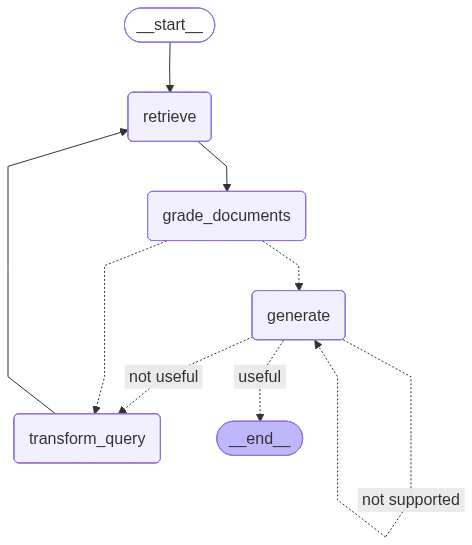

In [30]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
from pprint import pprint

inputs = {"question": "다양한 유형의 에이전트 기억이 어떻게 작동하는지 설명하십시오."}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('다양한 유형의 에이전트 기억은 크게 감각 기억, 단기 기억, 장기 기억으로 나뉩니다. 감각 기억은 원시 입력(텍스트, 이미지 등)의 '
 '임베딩 표현을 학습하며, 단기 기억은 모델의 컨텍스트 창 내에서 정보를 일시적으로 저장하고 활용하는 인-컨텍스트 학습 방식입니다. 장기 '
 '기억은 외부 벡터 저장소를 활용해 무한에 가까운 정보를 장기간 저장하고 빠르게 검색할 수 있도록 지원합니다.')


In [ ]:
inputs = {"question": "생각의 사슬 프롬프트가 어떻게 작동하는지 설명해 주세요?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"
'\n---\n'
('생각의 사슬(Chain of Thought, CoT) 프롬프트는 모델에게 "단계별로 생각하라"는 지시를 통해 복잡한 문제를 여러 작은 '
 '단계로 나누어 해결하도록 유도합니다. 이를 통해 모델이 문제 해결 과정을 명확히 하고 성능을 향상시킬 수 있습니다. 확장된 방법인 '
 'Tree of Thoughts는 각 단계에서 여러 사고 가능성을 탐색하며 트리 구조로 문제를 해결합니다.')
